# Analyzing augmented data

In [15]:
import os
import numpy as np
import xml.etree.ElementTree as ET
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import glob
import io
from collections import namedtuple
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [16]:
BASE_DIR = r"F:\Minor Data Collection\Final Image Data\Monument Original\Merged_Original_Augmented"

In [17]:
image_feature_description = {
    'image/height': tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/width' : tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/filename' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/encoded' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/class/text':tf.io.FixedLenSequenceFeature(shape = (), dtype = tf.string, allow_missing = True),
    'image/object/class/label':tf.io.FixedLenSequenceFeature(shape = (), dtype = np.int64, allow_missing = True)
}

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

def _bytestring(parsed_example):
    byte_string = parsed_example['image/encoded']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [parsed_example['image/height'], parsed_example['image/width'], 3])
    parsed_example['image/encoded'] = image
    bbox = tf.stack([parsed_example['image/object/bbox/ymin'], parsed_example['image/object/bbox/xmin'], parsed_example['image/object/bbox/ymax'], parsed_example['image/object/bbox/xmax']], axis = -1)
    output_dict = {'image': image,
                  'objects': {
                      'bbox': bbox,
                      'label':parsed_example['image/object/class/label'],
                      'label_txt': parsed_example['image/object/class/text']
                  }}

    return output_dict

In [18]:
def tfrecord_decoder(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(_parse_data)
    dataset = dataset.map(_bytestring)
    return dataset

In [19]:
tfrecord_path = os.path.join("F:\Minor Data Collection\Final Image Data\Monument Original\TFRecord", 'test.tfrecord')

test_dataset = tfrecord_decoder(os.path.join(BASE_DIR, "test_aug.tfrecord"))

In [25]:
LABEL_PATH = r"F:\Minor Project\Monument Object Detection\helper\Report\all_there_is.csv"
ignore_list = ['kotilingeshvara', 'til mahadev narayan temple', 'king statue']
mistake_list = ['degutale temple', 'kritipur tower', 'degu tale']
correct_list = ['degu tale temple_KDS', 'kirtipur tower']

POSSIBLE_LABELS = dict()

def csv_to_label_map_dict(path):
    df = pd.read_csv(path)
    class_list = list(df['class'])
    final_class_list = list()
    for class_name in class_list:
        if class_name not in ignore_list and class_name not in correct_list:
            if class_name in mistake_list:
                if class_name == 'degutale temple' or class_name == 'degu tale':
                    class_name = correct_list[0]
                elif class_name == 'kritipur tower':
                    class_name = correct_list[1]
            final_class_list.append(class_name)
    class_index = 1
    res_dict = {}
    for class_label in final_class_list:
        res_dict[class_label] = class_index
        class_index += 1
    return res_dict
labels = csv_to_label_map_dict(LABEL_PATH)
monument_classes = list(labels.keys())

In [28]:
# monument_classes = ['bg'] + monument_classes
print(monument_classes)

['bg', 'badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kirtipur tower', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple']


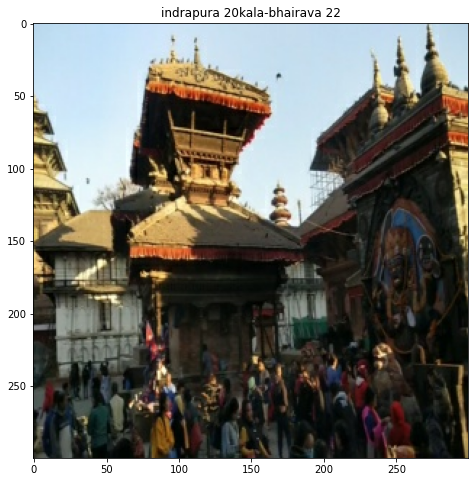

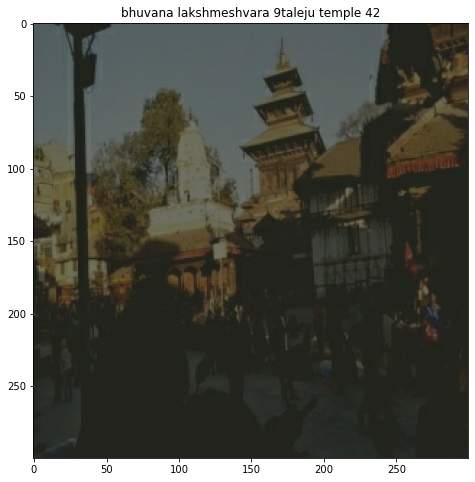

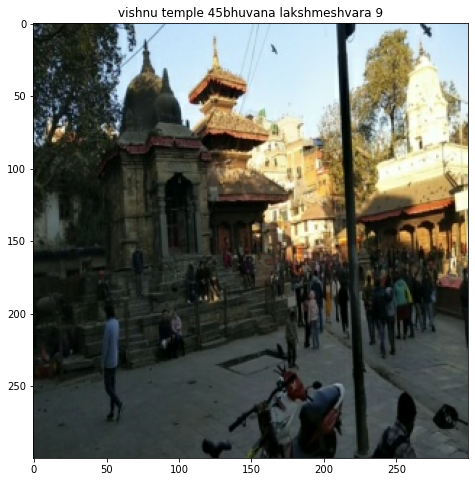

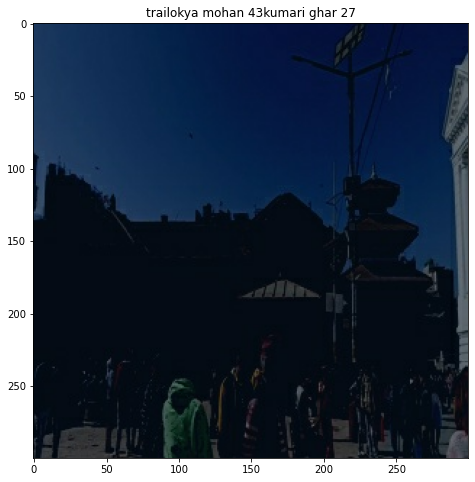

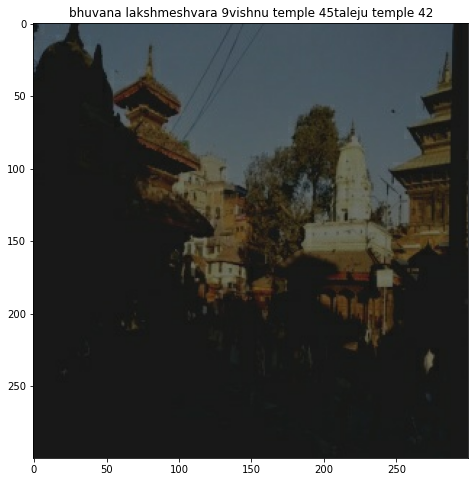

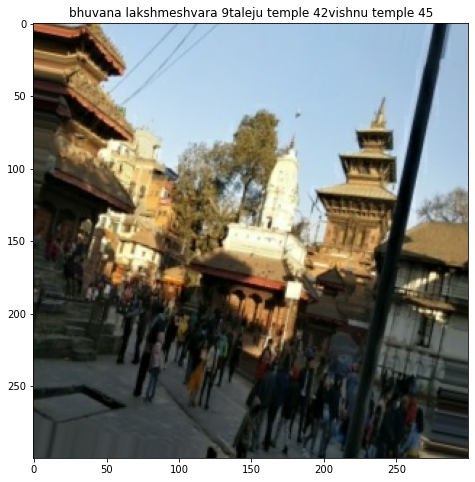

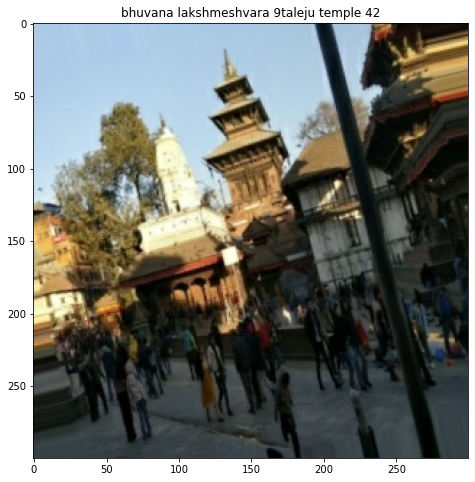

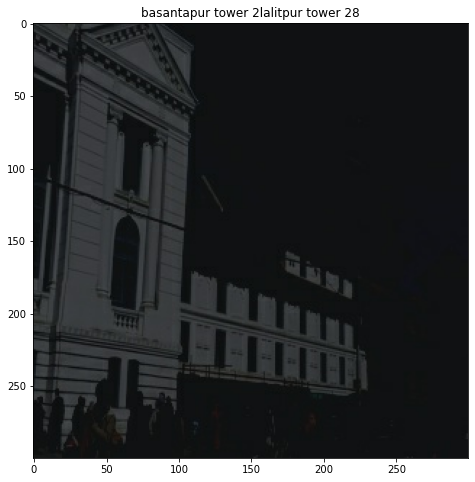

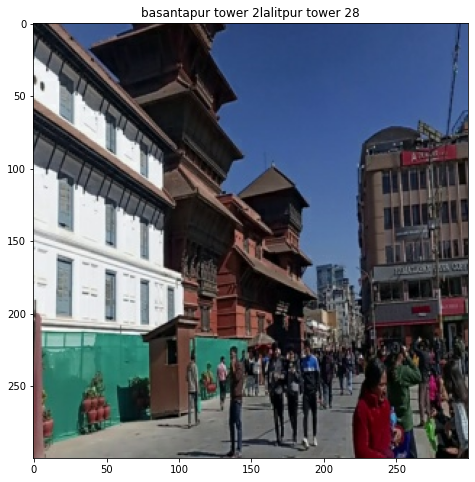

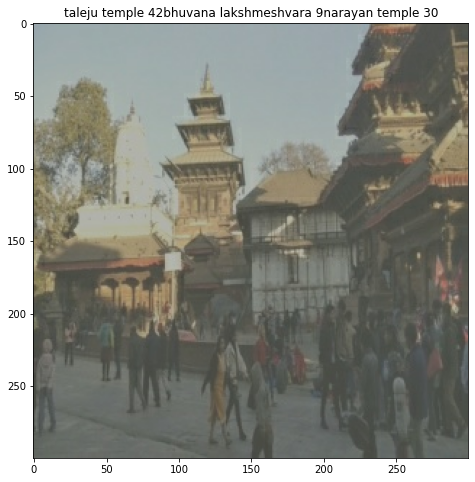

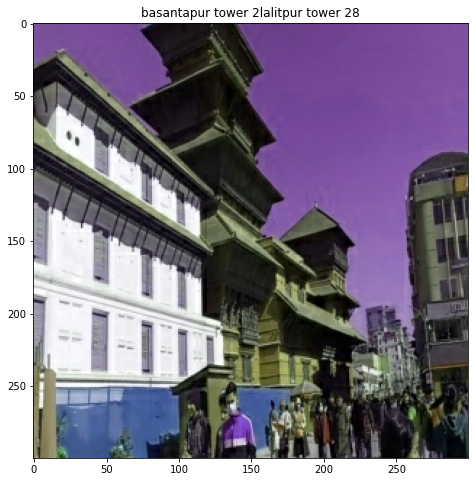

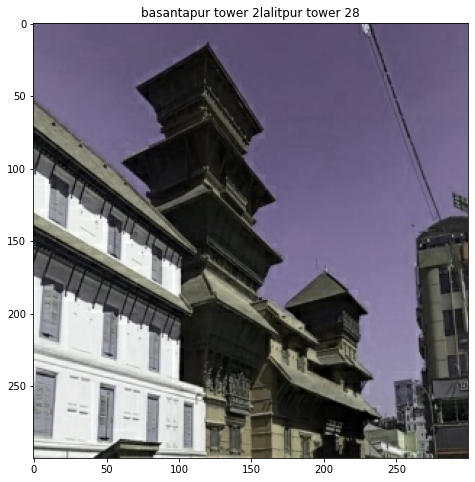

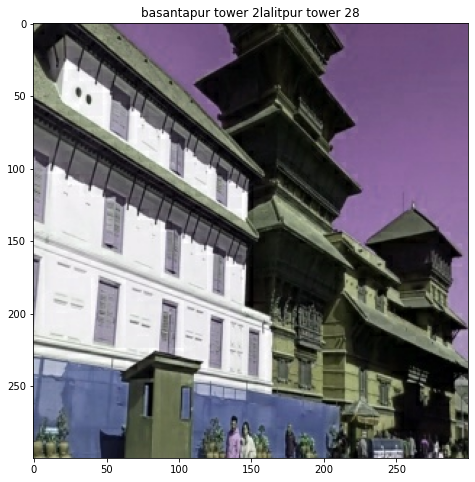

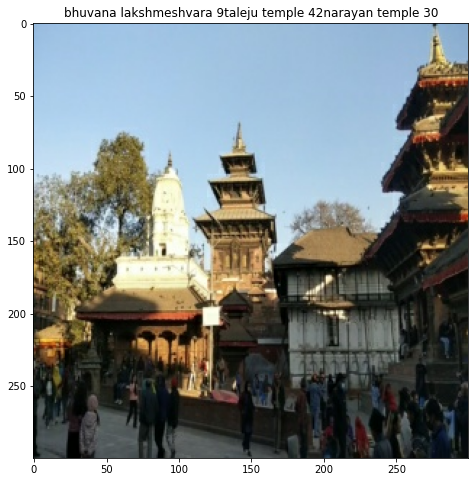

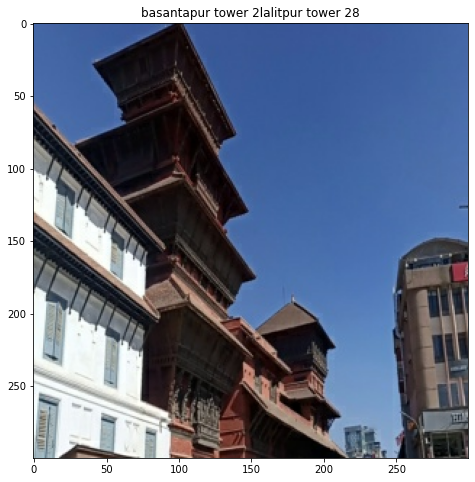

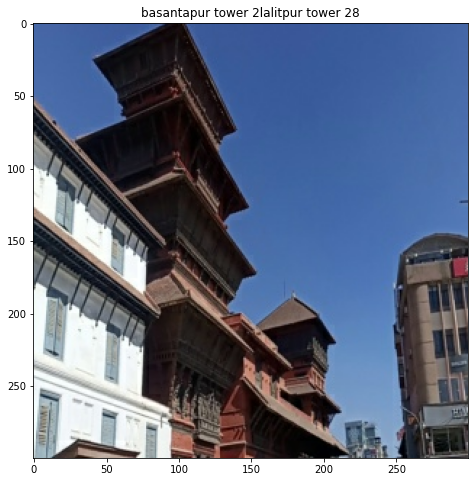

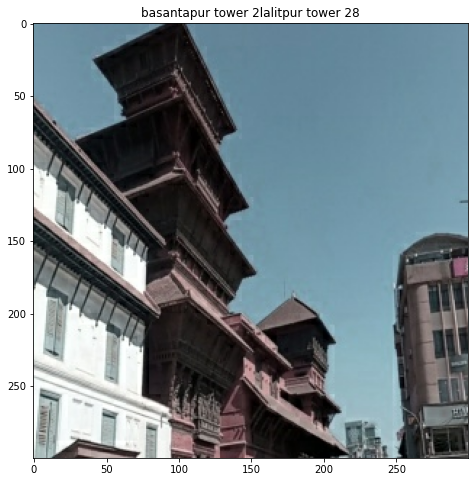

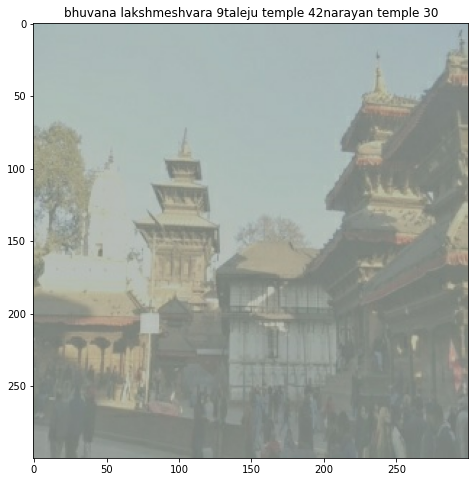

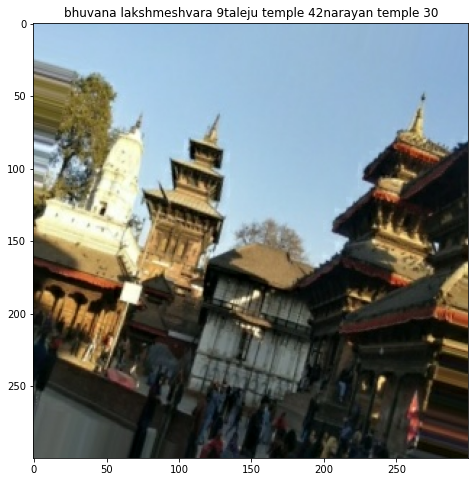

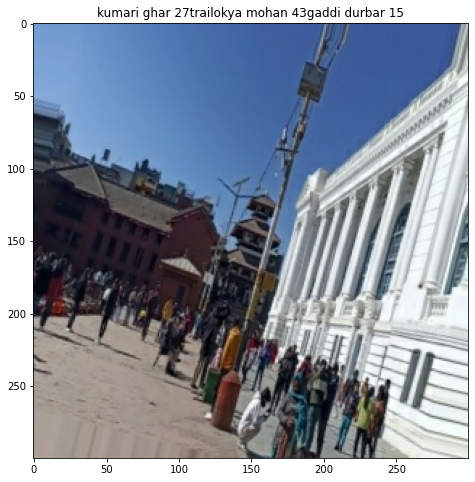

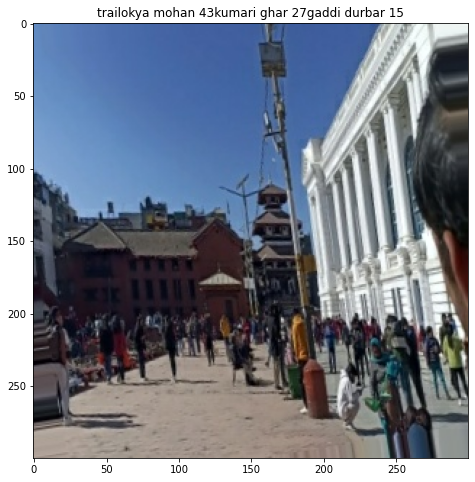

In [29]:
labels_list = []
count = 0

for ele in test_dataset:
    all_label = ''
    numpy_array = np.uint8(ele['image'].numpy())
    img = Image.fromarray(numpy_array)
    
    for label in ele['objects']['label'].numpy().tolist():
        if label not in labels_list:
            labels_list.append(label)
            
        all_label += monument_classes[label] + f" {label}"
    plt.figure(figsize = (8, 8))
    plt.title(all_label)
    plt.imshow(img)
    plt.show()
    count += 1
    if count > 20:
        break

In [ ]:
print(len(labels_list))


In [ ]:
list_1 = ['bg', 'badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple', 'Padding']
list_2 = ['bg','badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kirtipur tower', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple']




df_dict = {'trained_on': list_1, 'what should be': list_2}
df = pd.DataFrame(df_dict)


In [ ]:
df